In [10]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
np.set_printoptions(threshold=np.inf)

In [170]:
# Training data
app_train = pd.read_pickle('../home credit/application_train.pickle')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
app_test = pd.read_pickle('../home credit/application_test.pickle')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
app_train.drop('TARGET', axis=1, inplace=True)


cats = [f for f in app_train.columns if app_train.dtypes[f] == 'object']
nums = [f for f in app_train.columns if app_train.dtypes[f] != 'object']

app_train_num = app_train[nums]
app_train_cat = app_train[cats]

app_test_num = app_test[nums]
app_test_cat = app_test[cats]

app_train_cat.replace({np.nan : 'nan'}, inplace=True)
app_test_cat.replace({np.nan : 'nan'}, inplace=True)

cat_train_test = pd.concat([app_train_cat, app_test_cat], sort=False)
le = LabelEncoder()
for f in cat_train_test:
    cat_train_test[f] = le.fit_transform(cat_train_test[f])
app_train_cat = cat_train_test[:len(app_train_num)]
app_test_cat = cat_train_test[len(app_train_num):]
# 結合してからLEしないとずれてしまうことがある

train = pd.concat([app_train_num, app_train_cat], axis=1)
test = pd.concat([app_test_num, app_test_cat], axis=1)

train['train_or_test'] = 0
test['train_or_test'] = 1

data = pd.concat([train, test], sort=False).reset_index(drop=True)

In [173]:
data

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,train_or_test
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,...,3,1,8,6,5,3,0,5,0,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,...,1,1,3,1,39,3,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010033,-19046,-225,-4260.0,...,3,1,8,1,11,0,1,7,2,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008018,-19005,-3039,-9832.0,...,0,1,8,6,5,0,1,7,2,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028656,-19932,-3038,-4312.0,...,3,1,3,4,37,0,1,7,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,0,121500.0,412560.0,17473.5,270000.0,0.002043,-19970,-5169,-9096.0,...,5,1,18,6,33,0,1,7,2,1
356251,456222,2,157500.0,622413.0,31909.5,495000.0,0.035797,-11186,-1149,-3016.0,...,1,1,14,1,51,0,1,7,2,1
356252,456223,1,202500.0,315000.0,33205.5,315000.0,0.026398,-15922,-3037,-2680.0,...,1,1,18,6,5,0,0,5,0,1
356253,456224,0,225000.0,450000.0,25128.0,450000.0,0.018845,-13968,-2731,-1461.0,...,1,1,10,1,42,0,0,4,0,1


In [174]:
def plot_feature_importances(df):

    df = df.sort_values('importance', ascending = False).reset_index()
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 122 entries, SK_ID_CURR to train_or_test
dtypes: float16(61), float32(4), int16(2), int32(18), int64(1), int8(36)
memory usage: 87.7 MB


# LGBM

In [176]:
data['train_or_test'].value_counts()

0    307511
1     48744
Name: train_or_test, dtype: int64

In [177]:
X_train = data.drop(['train_or_test', 'SK_ID_CURR'], axis=1)
y_train = data['train_or_test']
y_train.astype(np.int8)

0         0
1         0
2         0
3         0
4         0
         ..
356250    1
356251    1
356252    1
356253    1
356254    1
Name: train_or_test, Length: 356255, dtype: int8

In [178]:
X_train

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,-2120,...,4,3,1,8,6,5,3,0,5,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,-291,...,1,1,1,3,1,39,3,0,0,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010033,-19046,-225,-4260.0,-2531,...,4,3,1,8,1,11,0,1,7,2
3,0,135000.0,312682.5,29686.5,297000.0,0.008018,-19005,-3039,-9832.0,-2437,...,4,0,1,8,6,5,0,1,7,2
4,0,121500.0,513000.0,21865.5,513000.0,0.028656,-19932,-3038,-4312.0,-3458,...,4,3,1,3,4,37,0,1,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,0,121500.0,412560.0,17473.5,270000.0,0.002043,-19970,-5169,-9096.0,-3399,...,4,5,1,18,6,33,0,1,7,2
356251,2,157500.0,622413.0,31909.5,495000.0,0.035797,-11186,-1149,-3016.0,-3003,...,4,1,1,14,1,51,0,1,7,2
356252,1,202500.0,315000.0,33205.5,315000.0,0.026398,-15922,-3037,-2680.0,-1504,...,4,1,1,18,6,5,0,0,5,0
356253,0,225000.0,450000.0,25128.0,450000.0,0.018845,-13968,-2731,-1461.0,-1364,...,1,1,1,10,1,42,0,0,4,0


In [179]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
356250    1
356251    1
356252    1
356253    1
356254    1
Name: train_or_test, Length: 356255, dtype: int64

In [180]:
import lightgbm as lgb
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=3, shuffle=True, random_state=100000)

feature_importance_df = pd.DataFrame()
col = list(X_train.columns)
i = 1
feat_df = pd.DataFrame()
preds = []
preds_test = []
va_indexes = []
train_score = []

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[valid_index]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]


    model = lgb.LGBMClassifier(n_estimators=300, random_state=42, importance='gain')

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_names=['train', 'valid'],
        eval_metric='auc',
        verbose=1000)
   
    fold_feat_df = pd.DataFrame()
    fold_feat_df["Feature_fold{}".format(i)] = col
    fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
    i += 1
    feat_df = pd.concat([feat_df, fold_feat_df], axis=1)

    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration_)
    
    tr_pred = model.predict_proba(X_tr)[:, 1]
    pred = model.predict_proba(X_val)[:, 1]
    preds.append(pred)
    va_indexes.append(valid_index)
    train_score.append(roc_auc_score(y_tr, tr_pred))

va_indexes = np.concatenate(va_indexes)
preds = np.concatenate(preds, axis=0)
order = np.argsort(va_indexes)
pred_train = pd.DataFrame(preds[order])
print('train Score : {:.6f}' .format(np.mean(train_score)))
print('valid Score : {:.6f}' .format(roc_auc_score(y_train, pred_train)))

train Score : 0.925677
valid Score : 0.897997


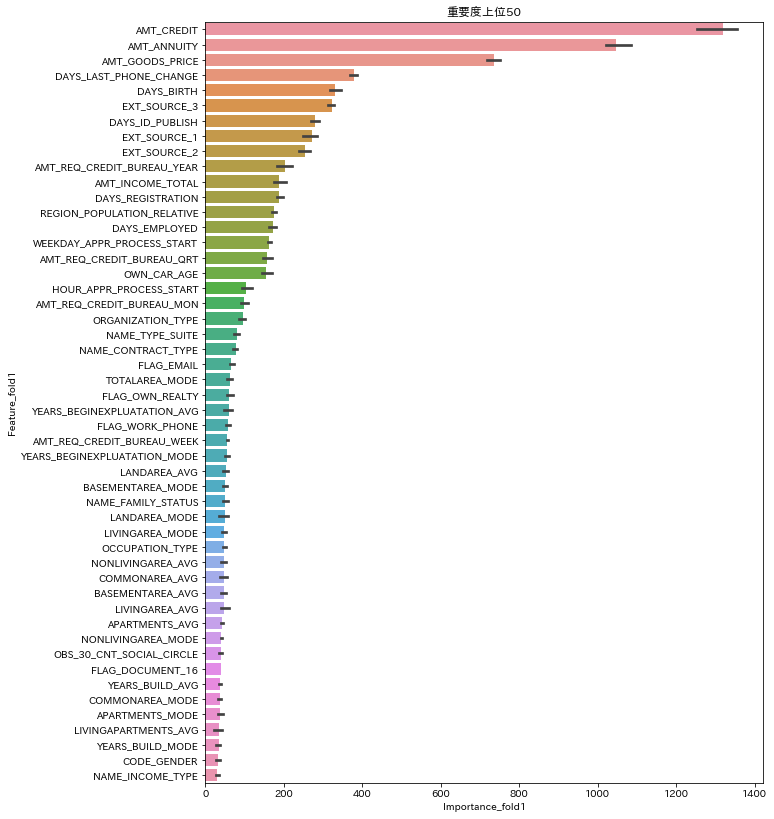

In [181]:
def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    # d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    # e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    
    feat = pd.concat([a, b, c]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)[["Feature_fold1",'Importance_fold1']]
    plt.figure(figsize=(10,14))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices.iloc[:50, 0])
    return indices
indices1 = feature_importance_plot(feat_df)

In [182]:
top10_importance = indices['Feature_fold1'][:10].tolist()
top10_importance

['AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_INCOME_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'DAYS_BIRTH']

<Figure size 864x1440 with 0 Axes>

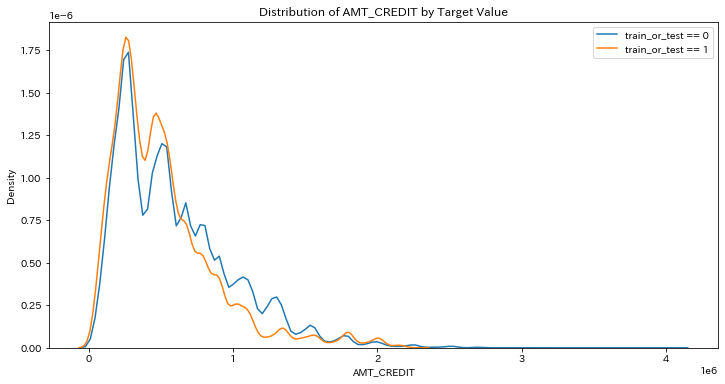

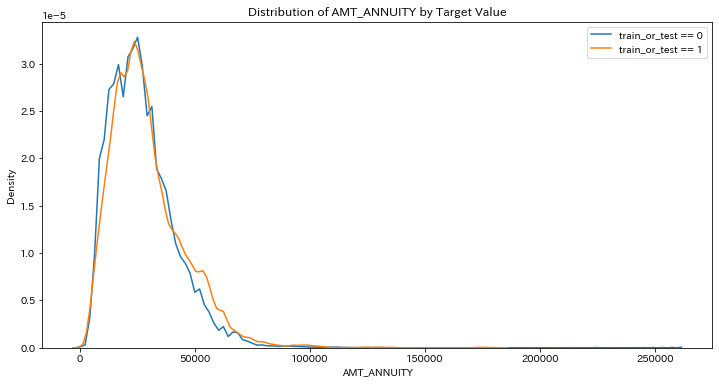

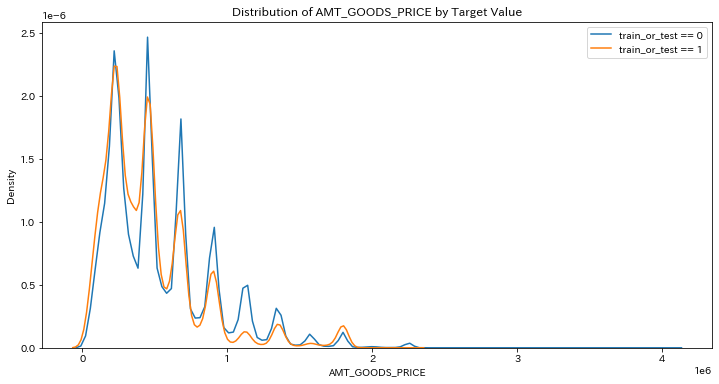

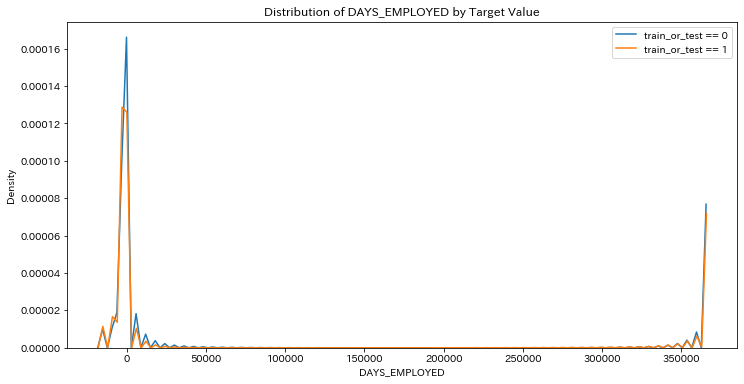

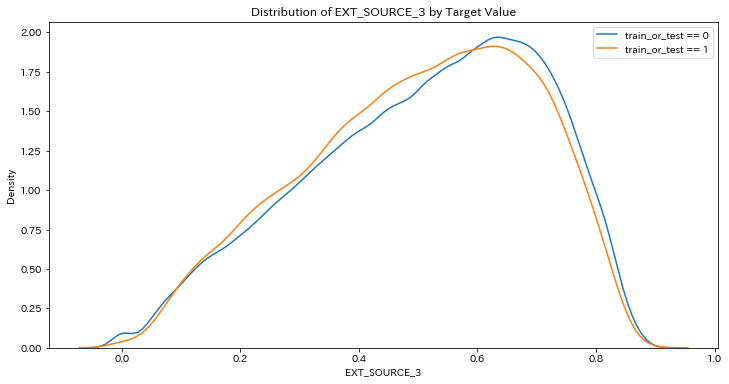

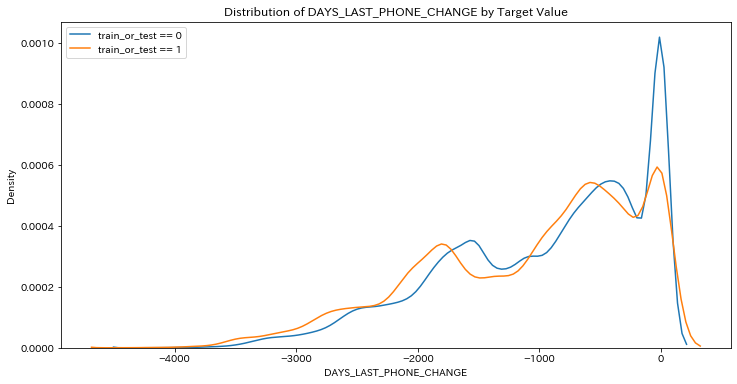

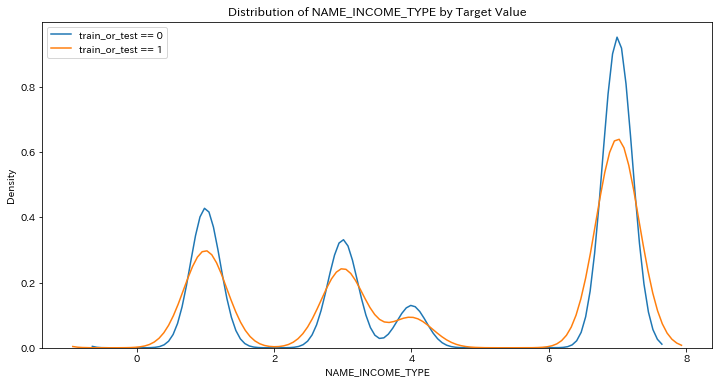

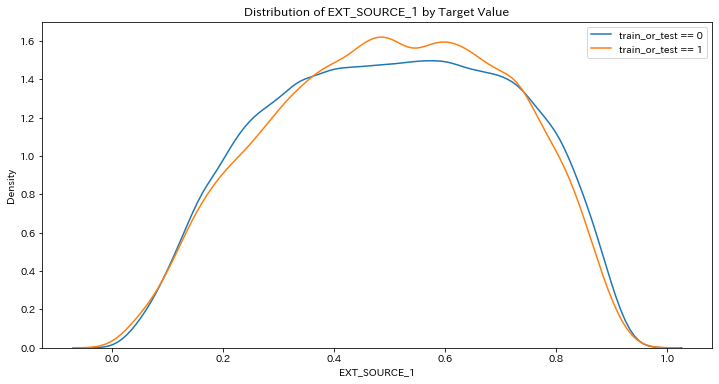

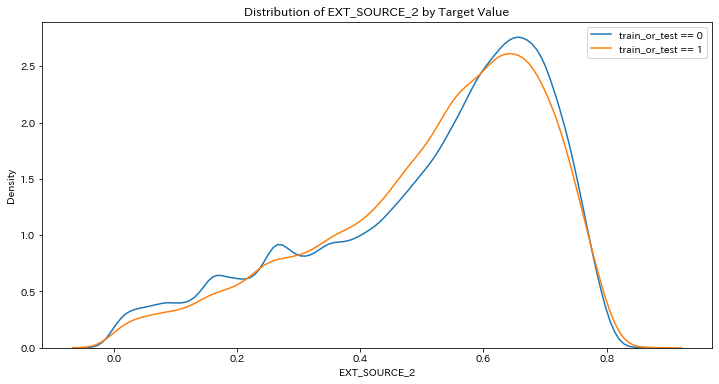

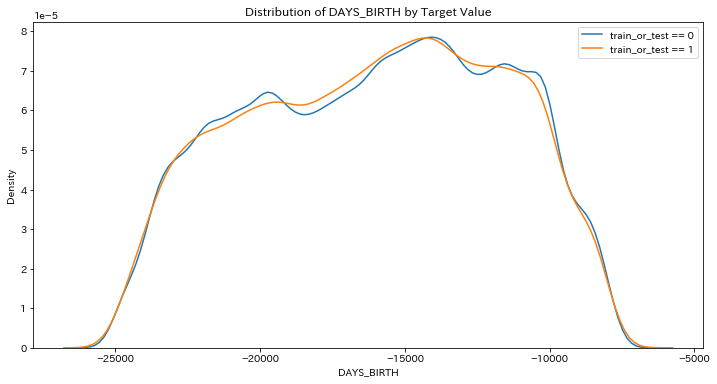

In [183]:
data = pd.concat([train, test], sort=False).reset_index(drop=True)
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(top10_importance):
    
    
    
    plt.figure(figsize=(12,6))
    sns.kdeplot(data.loc[data['train_or_test'] == 0, feature], label = 'train_or_test == 0')
    
    sns.kdeplot(data.loc[data['train_or_test'] == 1, feature], label = 'train_or_test == 1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

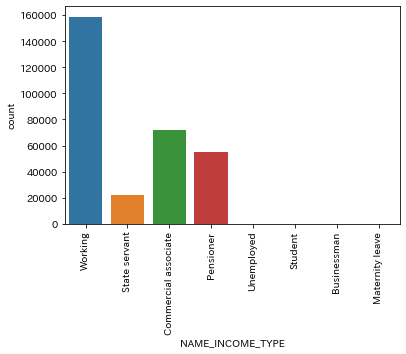

In [184]:
sns.countplot('NAME_INCOME_TYPE', data=app_train)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

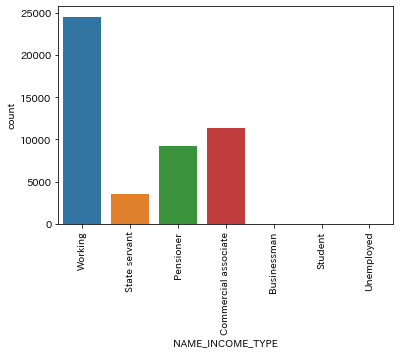

In [185]:
sns.countplot('NAME_INCOME_TYPE', data=app_test)
plt.xticks(rotation=90)

# importanceで抜く

In [186]:
top3_importance = indices['Feature_fold1'][:3].tolist()

In [187]:
X_train = data.drop(['train_or_test', 'SK_ID_CURR'], axis=1)
X_train = X_train.drop(top3_importance, axis=1)
y_train = data['train_or_test']
y_train = y_train.astype(np.int8)

In [188]:
import lightgbm as lgb
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=3, shuffle=True, random_state=100000)

feature_importance_df = pd.DataFrame()
col = list(X_train.columns)
i = 1
feat_df = pd.DataFrame()
preds = []
preds_test = []
va_indexes = []
train_score = []

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[valid_index]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]


    model = lgb.LGBMClassifier(n_estimators=300, random_state=42, importance='gain')

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_names=['train', 'valid'],
        eval_metric='auc',
        verbose=1000)
   
    fold_feat_df = pd.DataFrame()
    fold_feat_df["Feature_fold{}".format(i)] = col
    fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
    i += 1
    feat_df = pd.concat([feat_df, fold_feat_df], axis=1)

    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration_)
    
    tr_pred = model.predict_proba(X_tr)[:, 1]
    pred = model.predict_proba(X_val)[:, 1]
    preds.append(pred)
    va_indexes.append(valid_index)
    train_score.append(roc_auc_score(y_tr, tr_pred))

va_indexes = np.concatenate(va_indexes)
preds = np.concatenate(preds, axis=0)
order = np.argsort(va_indexes)
pred_train = pd.DataFrame(preds[order])
print('train Score : {:.6f}' .format(np.mean(train_score)))
print('valid Score : {:.6f}' .format(roc_auc_score(y_train, pred_train)))

train Score : 0.863480
valid Score : 0.814545


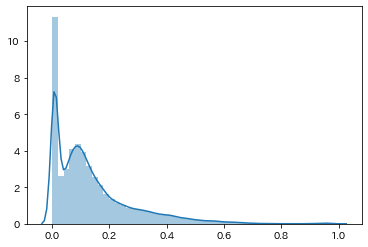

In [189]:
sns.distplot(pred)

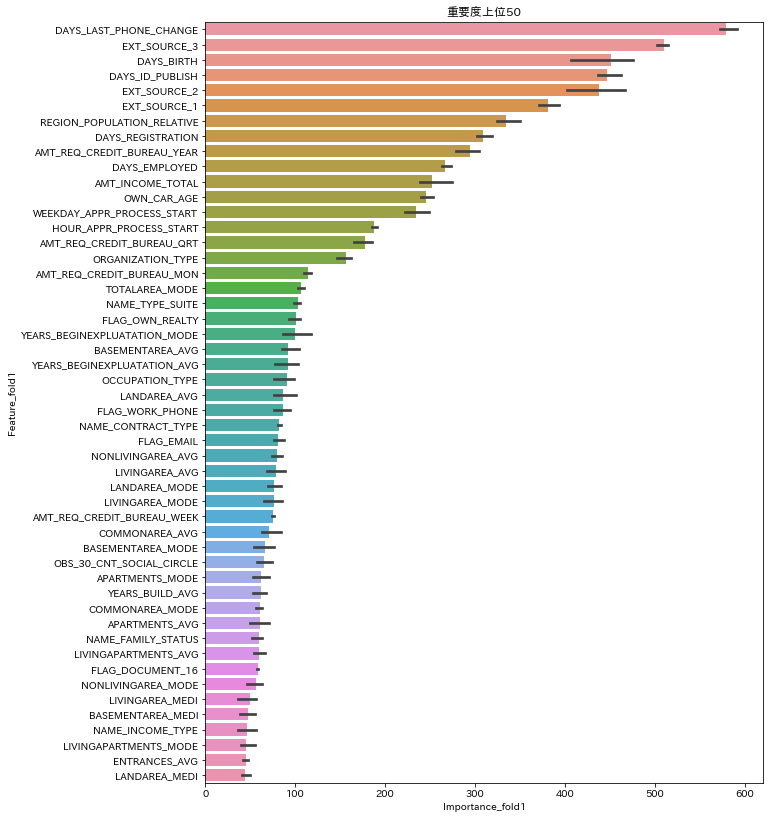

In [190]:
indices2 = feature_importance_plot(feat_df)

# baselineから、今回出てきた特徴量を削ってみる

### まずは抜かずに

In [191]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [192]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_indexes = []
    train_score = []
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=6785)
    
    feature_importance_df = pd.DataFrame()
    col = list(train_x.columns)
    i = 1
    feat_df = pd.DataFrame()
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x, train_y)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        
        model.fit(tr_x, tr_y, 
                  eval_set= [(tr_x, tr_y), (va_x, va_y)],
                  eval_metric='auc',
                  verbose=1000, 
                  early_stopping_rounds=20)
        
        
        tr_pred = model.predict_proba(tr_x)[:, 1]
        pred = model.predict_proba(va_x)[:, 1]
        preds.append(pred)
        pred_test = model.predict_proba(test_x)[:, 1]
        preds_test.append(pred_test)
        va_indexes.append(va_idx)
        
        fold_feat_df = pd.DataFrame()
        fold_feat_df["Feature_fold{}".format(i)] = col
        fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
        i += 1
        feat_df = pd.concat([feat_df, fold_feat_df], axis=1)
        print('  score Train : {:.6f}' .format(roc_auc_score(tr_y, tr_pred)), 
              '  score Valid : {:.6f}' .format(roc_auc_score(va_y, pred)))
        train_score.append(roc_auc_score(tr_y, tr_pred))
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    print('*'*40)
    print('train Score : {:.6f}' .format(np.mean(train_score)))
    print('valid Score : {:.6f}' .format(roc_auc_score(train_y, pred_train)))
    return pred_train, preds_test, model, feat_df

In [193]:
POS_CASH_balance = pd.read_pickle('../home credit/POS_CASH_balance.pickle')
bureau_balance = pd.read_pickle('../home credit/bureau_balance.pickle')
application_train = pd.read_pickle('../home credit/application_train.pickle')
previous_application = pd.read_pickle('../home credit/previous_application.pickle')
installments_payments = pd.read_pickle('../home credit/installments_payments.pickle')
credit_card_balance = pd.read_pickle('../home credit/credit_card_balance.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')
bureau = pd.read_pickle('../home credit/bureau.pickle')
description = pd.read_csv('../home credit/HomeCredit_columns_description.csv', index_col=0).iloc[:,0:5]
pd.options.display.max_colwidth = 20000
def search_description(column):
    return description.loc[description.Row == column][['Description','日本語訳']]

In [194]:
df = application_train
test_df = application_test
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()
df = df[df['CODE_GENDER'] != 'XNA']

docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
len(docs),len(live)

df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
df['MANY_CHILDREN'] = (df["CNT_CHILDREN"] > 5) * 1
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
df, cat_cols = one_hot_encoder(df)
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
df.drop(['SK_ID_CURR'], axis=1, inplace=True)

Train samples: 307511, test samples: 48744


In [195]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()].reset_index()
train_y = train_df['TARGET']
train_df.drop(['index', 'TARGET'], axis=1, inplace=True)
test_df.drop(['TARGET','index', 'level_0'], axis=1, inplace=True)
train_df.shape, test_df.shape

((307507, 280), (48744, 280))

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[185]	training's auc: 0.824363	training's binary_logloss: 0.224528	valid_1's auc: 0.766084	valid_1's binary_logloss: 0.24364
  score Train : 0.824363   score Valid : 0.766084
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[130]	training's auc: 0.810217	training's binary_logloss: 0.229609	valid_1's auc: 0.769746	valid_1's binary_logloss: 0.242729
  score Train : 0.810217   score Valid : 0.769746
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	training's auc: 0.806112	training's binary_logloss: 0.230869	valid_1's auc: 0.767905	valid_1's binary_logloss: 0.243534
  score Train : 0.806112   score Valid : 0.767905
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[135]	training's auc: 0.811161	training's binary_logloss: 0.229115	valid_1's auc: 0.76848

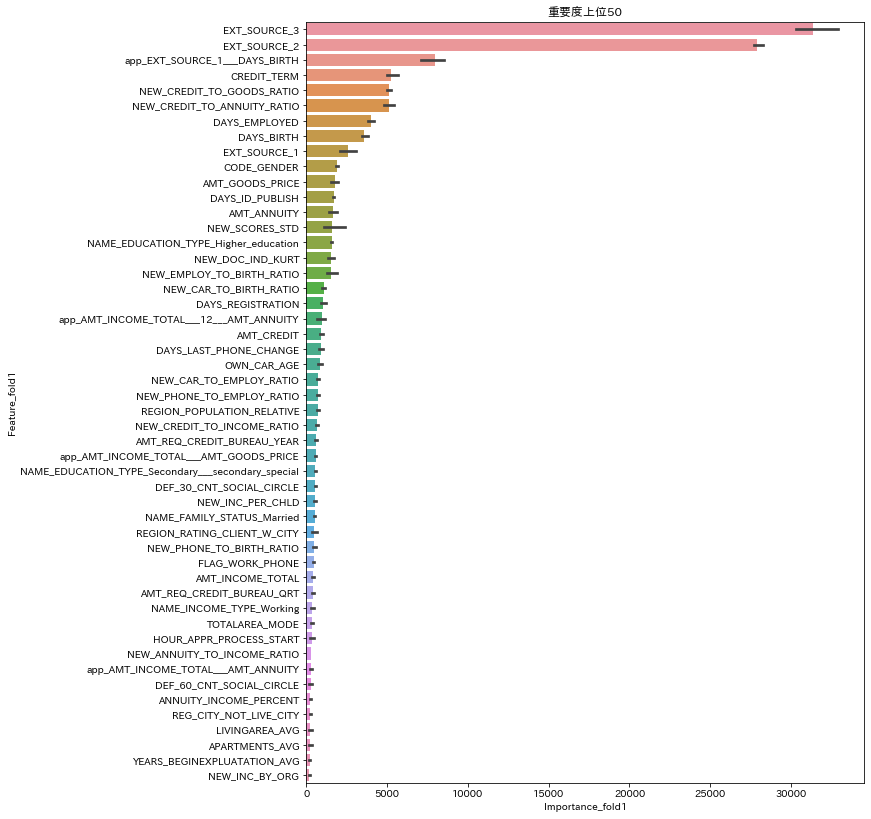

In [196]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df)
indices3 = feature_importance_plot(feat_df)

In [197]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)

### 抜いてみる

In [198]:
top5_importance

['AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_3']

In [199]:
application_train = pd.read_pickle('../home credit/application_train.pickle')
application_test = pd.read_pickle('../home credit/application_test.pickle')

In [200]:
top5_importance = indices['Feature_fold1'][:5].tolist()
df = application_train.drop(top5_importance, axis=1)
test_df = application_test.drop(top5_importance, axis=1)
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()
df = df[df['CODE_GENDER'] != 'XNA']

docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
len(docs),len(live)

inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']


df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
df['MANY_CHILDREN'] = (df["CNT_CHILDREN"] > 5) * 1


def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
df, cat_cols = one_hot_encoder(df)
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
df.drop(['SK_ID_CURR'], axis=1, inplace=True)

Train samples: 307511, test samples: 48744


In [201]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()].reset_index()
train_y = train_df['TARGET']
train_df.drop(['index', 'TARGET'], axis=1, inplace=True)
test_df.drop(['TARGET','index', 'level_0'], axis=1, inplace=True)
train_df.shape, test_df.shape

((307507, 260), (48744, 260))

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	training's auc: 0.75465	training's binary_logloss: 0.247774	valid_1's auc: 0.721982	valid_1's binary_logloss: 0.255558
  score Train : 0.754650   score Valid : 0.721982
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[103]	training's auc: 0.761312	training's binary_logloss: 0.246062	valid_1's auc: 0.721756	valid_1's binary_logloss: 0.255844
  score Train : 0.761312   score Valid : 0.721756
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	training's auc: 0.757112	training's binary_logloss: 0.247039	valid_1's auc: 0.716514	valid_1's binary_logloss: 0.256706
  score Train : 0.757112   score Valid : 0.716514
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[103]	training's auc: 0.760816	training's binary_logloss: 0.245992	valid_1's auc: 0.718724	

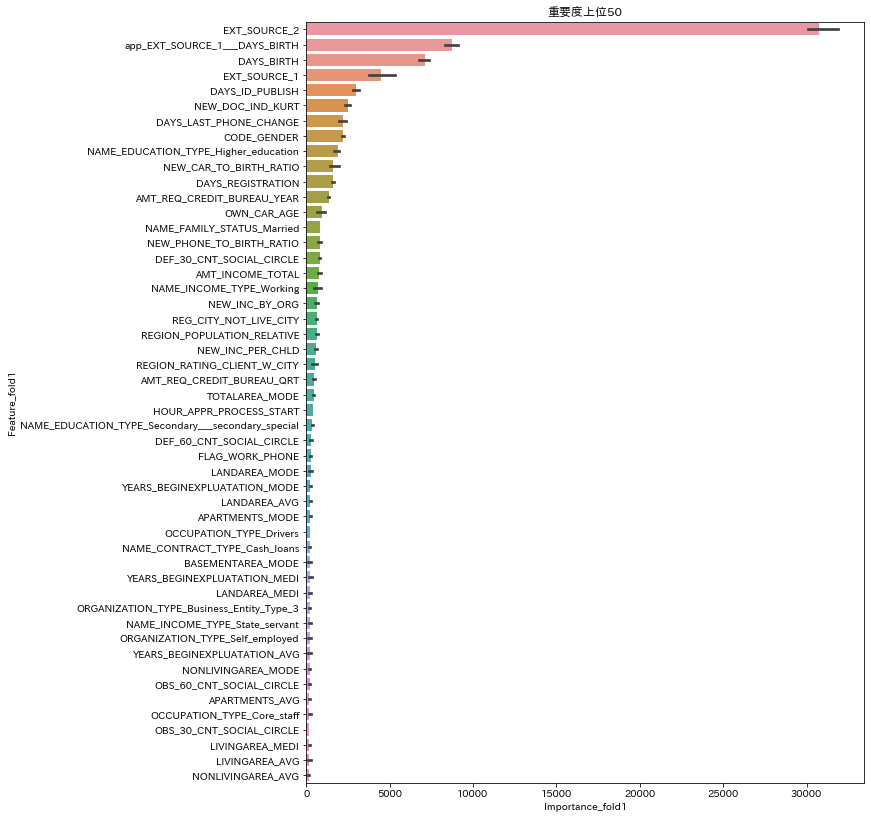

In [202]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df)
indices3 = feature_importance_plot(feat_df)

In [203]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)

# submitと手元スコアの差

### Adversarial Validation反映前

In [204]:
print('validとsubmitのスコアの差：{:.6f}'.format(0.767336-0.76602))

validとsubmitのスコアの差：0.001316


### Adversarial Validation反映後

In [205]:
print('validとsubmitのスコアの差：{:.6f}'.format(0.719553-0.70160))

validとsubmitのスコアの差：0.017953


 ADのスコアをすごい低くする（0.75とか）

 valid_predの高いもの（テストっぽくないものを除外したい）を削って、testっぽいものだけで組む。いろいろなところで切ってみてbaselineのスコアを確認

# データセットをテストっぽくする

In [266]:
app_train = pd.read_pickle('../home credit/application_train.pickle')
app_test = pd.read_pickle('../home credit/application_test.pickle')
app_train.drop('TARGET', axis=1, inplace=True)

cats = [f for f in app_train.columns if app_train.dtypes[f] == 'object']
nums = [f for f in app_train.columns if app_train.dtypes[f] != 'object']

app_train_num = app_train[nums]
app_train_cat = app_train[cats]

app_test_num = app_test[nums]
app_test_cat = app_test[cats]

app_train_cat.replace({np.nan : 'nan'}, inplace=True)
app_test_cat.replace({np.nan : 'nan'}, inplace=True)

cat_train_test = pd.concat([app_train_cat, app_test_cat], sort=False)
le = LabelEncoder()
for f in cat_train_test:
    cat_train_test[f] = le.fit_transform(cat_train_test[f])
app_train_cat = cat_train_test[:len(app_train_num)]
app_test_cat = cat_train_test[len(app_train_num):]
# 結合してからLEしないとずれてしまうことがある

train = pd.concat([app_train_num, app_train_cat], axis=1)
test = pd.concat([app_test_num, app_test_cat], axis=1)

train['train_or_test'] = 0
test['train_or_test'] = 1

data = pd.concat([train, test], sort=False).reset_index(drop=True)

In [267]:
X_train = data.drop(['train_or_test', 'SK_ID_CURR'], axis=1)
y_train = data['train_or_test']
y_train.astype(np.int8)

0         0
1         0
2         0
3         0
4         0
         ..
356250    1
356251    1
356252    1
356253    1
356254    1
Name: train_or_test, Length: 356255, dtype: int8

In [269]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=3, shuffle=True, random_state=100000)

feature_importance_df = pd.DataFrame()
col = list(X_train.columns)
i = 1
feat_df = pd.DataFrame()
preds = []
preds_test = []
va_indexes = []
train_score = []

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[valid_index]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]


    model = lgb.LGBMClassifier(n_estimators=300, random_state=42, importance='gain')

    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_names=['train', 'valid'],
        eval_metric='log_loss',
        verbose=1000)
   
    fold_feat_df = pd.DataFrame()
    fold_feat_df["Feature_fold{}".format(i)] = col
    fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
    i += 1
    feat_df = pd.concat([feat_df, fold_feat_df], axis=1)

    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration_)
    
    tr_pred = model.predict_proba(X_tr)[:, 1]
    pred = model.predict_proba(X_val)[:, 1]
    preds.append(pred)
    va_indexes.append(valid_index)
    train_score.append(roc_auc_score(y_tr, tr_pred))

va_indexes = np.concatenate(va_indexes)
preds = np.concatenate(preds, axis=0)
order = np.argsort(va_indexes)
pred_train1 = pd.DataFrame(preds[order])
print('train Score : {:.6f}' .format(np.mean(train_score)))
print('valid Score : {:.6f}' .format(roc_auc_score(y_train, pred_train1)))

train Score : 0.925677
valid Score : 0.897997


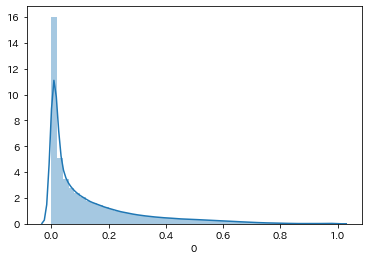

In [271]:
sns.distplot(pred_train1.iloc[:,0])

In [272]:
pred_train1.columns = ['proba']
pred_train1 = pred_train1[:len(train)]
pred_train1

,proba
0,0.105084
1,0.009107
2,0.012121
3,0.210925
4,0.012750
...,...
307506,0.072766
307507,0.010418
307508,0.004669
307509,0.132908


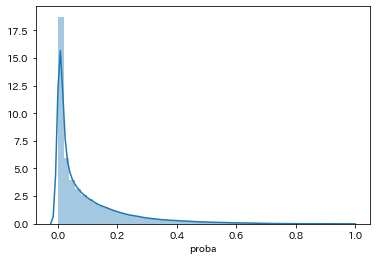

In [273]:
sns.distplot(pred_train1['proba'])

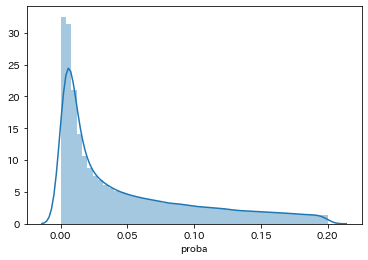

In [274]:
sns.distplot(pred_train1[pred_train1['proba'] < 0.2]['proba'])

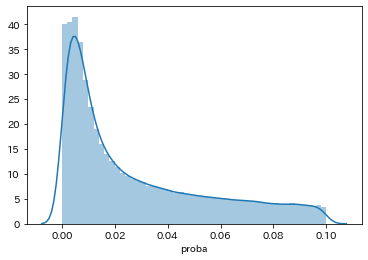

In [275]:
sns.distplot(pred_train1[pred_train1['proba'] < 0.1]['proba'])

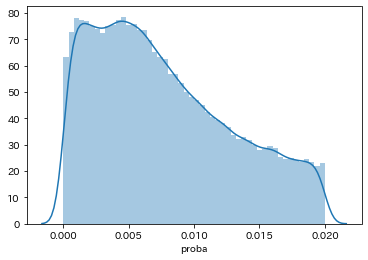

In [300]:
sns.distplot(pred_train1[pred_train1['proba'] < 0.02]['proba'])

In [301]:
low_proba = pred_train1[pred_train1['proba'] > 0.005]
low_proba

,proba
0,0.105084
1,0.009107
2,0.012121
3,0.210925
4,0.012750
...,...
307505,0.005256
307506,0.072766
307507,0.010418
307509,0.132908


In [302]:
train_new = train.loc[low_proba.index.tolist(), :]
train_new

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,train_or_test
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,...,3,1,8,6,5,3,0,5,0,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,...,1,1,3,1,39,3,0,0,0,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010033,-19046,-225,-4260.0,...,3,1,8,1,11,0,1,7,2,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008018,-19005,-3039,-9832.0,...,0,1,8,6,5,0,1,7,2,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028656,-19932,-3038,-4312.0,...,3,1,3,4,37,0,1,7,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307505,456249,0,112500.0,225000.0,22050.0,225000.0,0.022797,-24384,365243,-7368.0,...,3,1,18,1,57,3,0,4,0,0
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032562,-9327,-236,-8456.0,...,2,5,14,4,43,3,0,5,0,0
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025162,-20775,365243,-4388.0,...,5,1,18,1,57,3,0,5,0,0
307509,456254,0,171000.0,370107.0,20205.0,319500.0,0.005314,-11961,-4786,-2562.0,...,1,1,8,6,3,0,0,5,0,0


In [303]:
app_train = pd.read_pickle('../home credit/application_train.pickle')
train_new_ta = train_new.merge(app_train[['SK_ID_CURR','TARGET']], on='SK_ID_CURR', how='left')
df = train_new_ta
test_df = application_test
print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
df = df.append(test_df).reset_index()
df = df[df['CODE_GENDER'] != 'XNA']

docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
len(docs),len(live)

df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
df['MANY_CHILDREN'] = (df["CNT_CHILDREN"] > 5) * 1
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
df, cat_cols = one_hot_encoder(df)
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
df.drop(['SK_ID_CURR'], axis=1, inplace=True)

Train samples: 265150, test samples: 48744


In [304]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()].reset_index()
train_y = train_df['TARGET']
train_df.drop(['index', 'TARGET'], axis=1, inplace=True)
test_df.drop(['TARGET','index', 'level_0'], axis=1, inplace=True)
train_df.shape, test_df.shape

((265150, 417), (48744, 417))

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	training's auc: 0.81812	training's binary_logloss: 0.231126	valid_1's auc: 0.768642	valid_1's binary_logloss: 0.247948
  score Train : 0.818120   score Valid : 0.768642
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[146]	training's auc: 0.817421	training's binary_logloss: 0.231185	valid_1's auc: 0.767782	valid_1's binary_logloss: 0.247988
  score Train : 0.817421   score Valid : 0.767782
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	training's auc: 0.817101	training's binary_logloss: 0.231635	valid_1's auc: 0.764745	valid_1's binary_logloss: 0.248486
  score Train : 0.817101   score Valid : 0.764745
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[146]	training's auc: 0.819828	training's binary_logloss: 0.230427	valid_1's auc: 0.76895

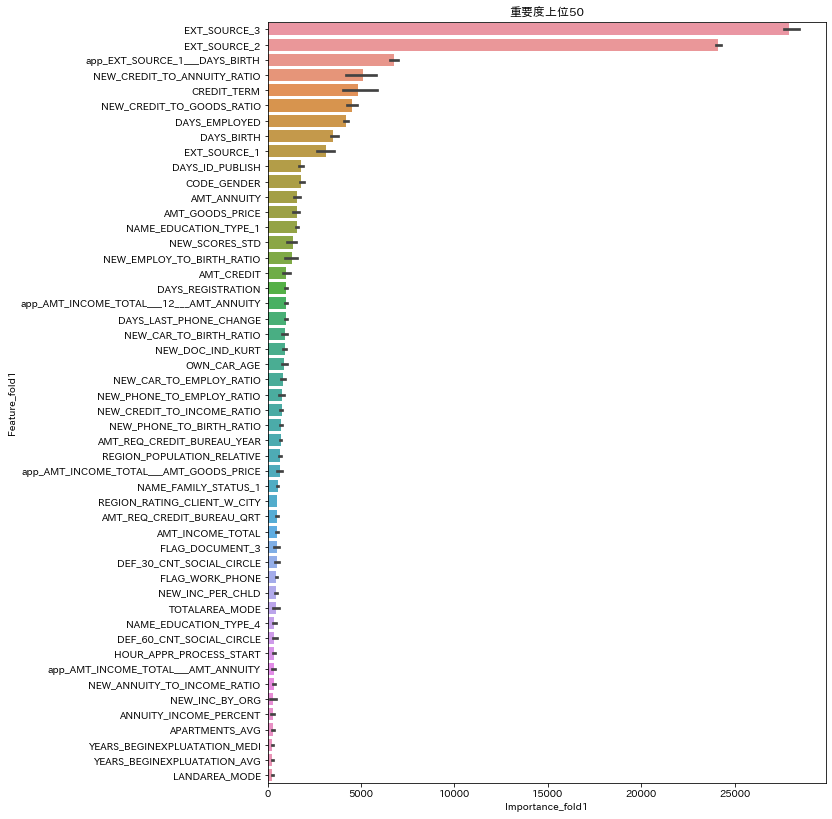

In [305]:
model = lgb.LGBMClassifier(
            nthread=4,
            n_estimators=1000,
            learning_rate=0.1,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            importance_type='gain')

pred_train, preds_test, lgbm , feat_df= predict_cv(model, train_df, train_y, test_df)
indices5 = feature_importance_plot(feat_df)

In [306]:
sub = application_test[['SK_ID_CURR']].copy()
sub['TARGET'] = preds_test
sub.to_csv('sub.csv', index= False)

In [308]:
print('そのまま      validとsubmitのスコアの差：{:.6f}'.format(0.767336-0.76602))
print('proba>0.05    validとsubmitのスコアの差：{:.6f}'.format(0.764897 - 0.75618))
print('proba>0.01    validとsubmitのスコアの差：{:.6f}'.format(0.767233 - 0.75779))
print('proba>0.005   validとsubmitのスコアの差：{:.6f}'.format(0.766851 - 0.75863))

# うーん

そのまま      validとsubmitのスコアの差：0.001316
proba>0.05    validとsubmitのスコアの差：0.008717
proba>0.01    validとsubmitのスコアの差：0.009443
proba>0.005   validとsubmitのスコアの差：0.008221
